# Optimize dual frame

This document shows you how to ...

In [1]:
%load_ext autoreload
%autoreload 2

## Quantum Circuit

### Define quantum circuit
The circuit can contain some ancilla qubits that you might not want to measure.

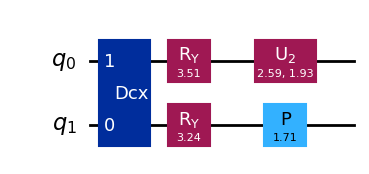

In [2]:
from qiskit.circuit.random import random_circuit

qc = random_circuit(2, 3, measure=False, seed=876)
qc.draw("mpl", style="iqp")

### Define measurement procedure

The `measurement_layout` argument specifies which qubits to measure. It can be seen as a map from virtual to physical qubits indices. In this example, we only want to measure qubits 1 and 3.

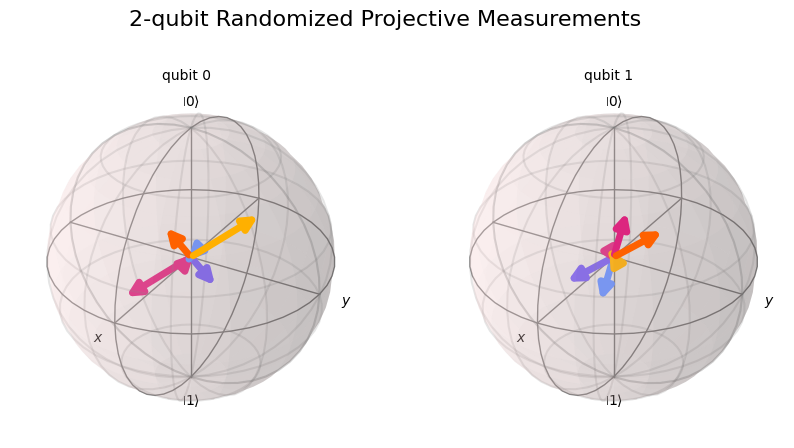

In [3]:
import numpy as np
from numpy.random import default_rng
from povm_toolbox.library import RandomizedProjectiveMeasurements

rng = default_rng(13)

n_qubit = 2

# Choose the angles at random
phi = 2 * np.pi * rng.uniform(0, 1, size=3 * n_qubit).reshape((n_qubit, 3))
theta = np.arccos(2 * rng.uniform(0, 1, size=3 * n_qubit).reshape((n_qubit, 3)) - 1.0)
angles = np.concatenate((theta, phi), axis=1)

# Also choose the bias at random
bias = rng.uniform(0, 1, size=3 * n_qubit).reshape((n_qubit, 3))
bias /= bias.sum(axis=1)[:, np.newaxis]

measurement = RandomizedProjectiveMeasurements(n_qubit, bias=bias, angles=angles, seed_rng=rng)
measurement.definition().draw_bloch(title=f"{n_qubit}-qubit Randomized Projective Measurements")

### Run the job

Initialize `Sampler` and `POVMSampler`. Then run the job.

In [4]:
from povm_toolbox.sampler import POVMSampler
from qiskit.primitives import StatevectorSampler

rng2 = default_rng(26)

sampler = StatevectorSampler(seed=rng2)
povm_sampler = POVMSampler(sampler=sampler)

job = povm_sampler.run([qc], shots=4096, povm=measurement)
pub_result = job.result()[0]

### Define observable

In [5]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["XI", "XX", "YY", "ZX"], coeffs=[1, 1, -1, 1])

### Get the expected value

In [6]:
from povm_toolbox.post_processor import POVMPostProcessor
from qiskit.quantum_info import Statevector

exact_expectation_value = np.real_if_close(Statevector(qc).expectation_value(observable))
print(f"Exact value:     {exact_expectation_value}")

post_processor = POVMPostProcessor(pub_result)

exp_value, std = post_processor.get_single_exp_value_and_std(observable)
print(f"Estimated value: {exp_value}")
print(f"\nEstimated standard deviation of the estimator: {std}")

Exact value:     -0.9586787923013959
Estimated value: -0.2349240987493174

Estimated standard deviation of the estimator: 0.4242132718498908


In [7]:
post_processor.optimize(state=Statevector(qc))

exp_value, std = post_processor.get_single_exp_value_and_std(observable)
print(f"Estimated value: {exp_value}")
print(f"\nEstimated standard deviation of the estimator: {std}")

Estimated value: -0.7898977675847263

Estimated standard deviation of the estimator: 0.1153789923630103
